In [1]:
from pathlib import Path
import random
import numpy as np
import optuna
from parse import parse

import os
import torch
from torch import optim, nn, utils, Tensor
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2

random.seed(69)

2023-05-26 20:42:09.725517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def parse_filename(name):
    #print(name)
    return parse("{subject}_{img_num:d}_{gender:d}_{glasses:d}_{eye_state:d}_{reflections:d}_{quality:d}_{sensor:d}.png", name)

parse_filename(next(next(Path("mrlEyes_2018_01").iterdir()).iterdir()).name)

<Result () {'subject': 's0007', 'img_num': 461, 'gender': 0, 'glasses': 0, 'eye_state': 0, 'reflections': 0, 'quality': 1, 'sensor': 1}>

In [3]:
import cv2
transform = A.ReplayCompose([
        A.RandomBrightnessContrast(brightness_limit=0.6, contrast_limit=0.2, brightness_by_max=False),
        A.ShiftScaleRotate(shift_limit=0.2, rotate_limit=15),
        A.LongestMaxSize(36),
        ToTensorV2(),
    ])

In [4]:
from torch.utils.data import Dataset

class MRLEyeDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform=transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        label = torch.as_tensor(parse_filename(self.imgs[idx].name)["eye_state"], dtype=torch.float)
        label = torch.reshape(label, (1,))
        if self.transform:
            img = self.transform(image=img)["image"]
        return img, label

In [5]:
TRAIN_TEST_SPLIT = 0.9
img_paths = list(Path("mrlEyes_2018_01").glob("**/*.png"))
split_idx = int(len(img_paths) * TRAIN_TEST_SPLIT)
train_paths = img_paths[:split_idx]
test_paths = img_paths[split_idx:]

train_dataset = MRLEyeDataset(train_paths, transform=transform)
test_dataset = MRLEyeDataset(test_paths, transform=transform)

len(img_paths)

84898

In [6]:
train_loader = utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [7]:
import torch.nn.functional as F
from torch.optim import lr_scheduler

from torchmetrics import Accuracy

class Dumb(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.conv2 = nn.Conv2d(4, 6, 3)
        self.fc1 = nn.Linear(6 * 7 * 7, 36)
        self.fc2 = nn.Linear(36, 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        y_hat = F.sigmoid(self.fc2(x))
        return y_hat


class DumbModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_acc = Accuracy(task="binary")
        self.val_acc = Accuracy(task="binary")

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.train_acc(y_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.binary_cross_entropy(y_hat, y)
        self.val_acc(y_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

   
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
        return [optimizer], [{"scheduler": scheduler, "monitor": "val_loss"}]

class AccCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = pl_module.log("train_acc_epoch", pl_module.train_acc, prog_bar=True)
    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = pl_module.log("val_acc_epoch", pl_module.val_acc, prog_bar=True)

In [8]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

dumb = Dumb()
model = DumbModel(dumb)

trainer = pl.Trainer(limit_train_batches=1.0, max_epochs=40, callbacks=[AccCallback(), EarlyStopping(monitor="val_loss", mode="min", patience=5)])
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | model     | Dumb           | 10.9 K
1 | train_acc | BinaryAccuracy | 0     
2 | val_acc   | BinaryAccuracy | 0     
---------------------------------------------
10.9 K    Trainable params
0         Non-trainable params
10.9 K    Total params
0.044     Total estimated model params size (MB)


Epoch 39: 100%|██████████| 299/299 [00:43<00:00,  6.81it/s, v_num=161, train_loss_step=0.105, val_loss=0.0809, val_acc_epoch=0.970, train_loss_epoch=0.0791, train_acc_epoch=0.971] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 299/299 [00:43<00:00,  6.81it/s, v_num=161, train_loss_step=0.105, val_loss=0.0809, val_acc_epoch=0.970, train_loss_epoch=0.0791, train_acc_epoch=0.971]


In [9]:
nb_classes = 2
device = 'cuda'

def confused(loader):
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(loader):
            outputs = dumb(inputs)
            preds = outputs > 0.5
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    return confusion_matrix

print(confused(train_loader), confused(test_loader))

tensor([[37332.,   763.],
        [ 1447., 36866.]]) tensor([[3746.,  105.],
        [ 146., 4493.]])


In [11]:
confusion_matrix = confused(test_loader)
torch.trace(confusion_matrix) / torch.sum(confusion_matrix)

tensor(0.9694)

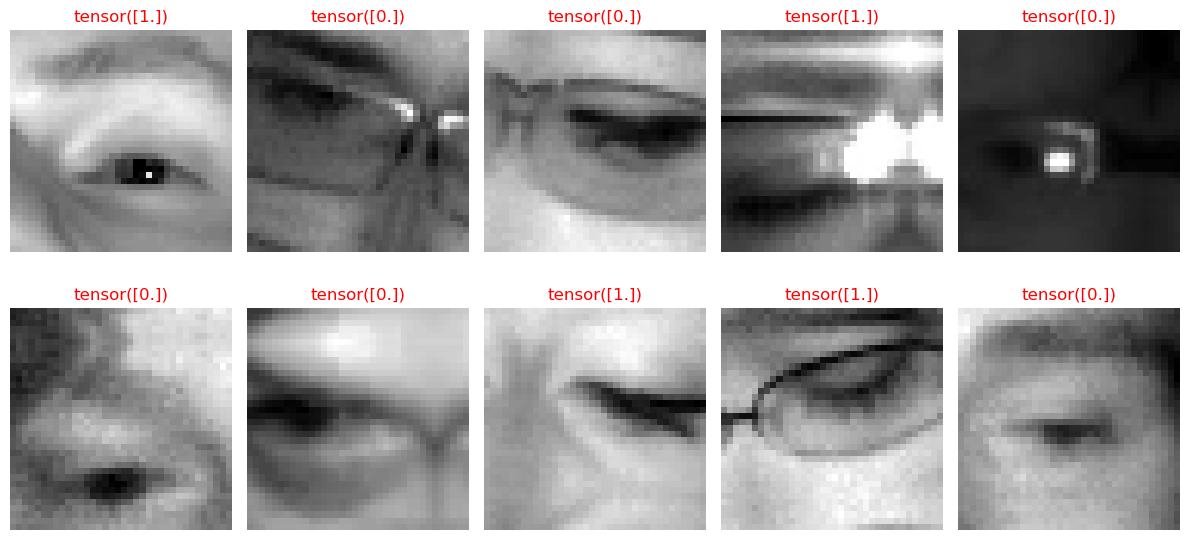

In [13]:
from matplotlib import pyplot as plt


def display_image_grid(dataloader, rows=2, cols=5):
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    bad_imgs = []
    bad_labels = []
    with torch.no_grad():
        for batch in dataloader:
            batch_x, batch_y = batch
            batch_y_hat = (dumb(batch_x) > 0.5).float()
            bad, _ = torch.where(batch_y != batch_y_hat)
            #print(bad)
            for bad_i in bad:
                bad_imgs.append(batch_x[bad_i])
                bad_labels.append(batch_y_hat[bad_i])
            if len(bad_imgs) >= rows*cols:
                break
    for i, img in enumerate(bad_imgs[:rows*cols]):
        ax.ravel()[i].imshow(img.reshape((36, 36)), cmap='gray')
        ax.ravel()[i].set_title(bad_labels[i], color='r')
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(train_loader)

see https://github.com/sithu31296/PyTorch-ONNX-TFLite for conversion tutorial

In [16]:
model_name = f"{sum(p.numel() for p in dumb.parameters()) // 1000}k_cnn"
print(model_name)
torch.save(dumb.state_dict(), f"{model_name}.torch")
ex_x, ex_y = next(iter(test_loader))
ex_x_1 = torch.unsqueeze(ex_x[0], 0)
torch.onnx.export(dumb, ex_x_1, f"{model_name}.onnx", input_names=["conv1"]) #dynamic_axes={"conv1": {0: "batch_size"}})

10k_cnn
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [17]:
import onnx

# Load the ONNX model
onnx_model = onnx.load(f"{model_name}.onnx")

# Check that the IR is well formed
onnx.checker.check_model(onnx_model)

# Print a Human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %conv1[FLOAT, 1x1x36x36]
) initializers (
  %conv1.weight[FLOAT, 4x1x3x3]
  %conv1.bias[FLOAT, 4]
  %conv2.weight[FLOAT, 6x4x3x3]
  %conv2.bias[FLOAT, 6]
  %fc1.weight[FLOAT, 36x294]
  %fc1.bias[FLOAT, 36]
  %fc3.weight[FLOAT, 1x36]
  %fc3.bias[FLOAT, 1]
) {
  %/conv1/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [1, 1]](%conv1, %conv1.weight, %conv1.bias)
  %/Relu_output_0 = Relu(%/conv1/Conv_output_0)
  %/MaxPool_output_0 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%/Relu_output_0)
  %/conv2/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [1, 1]](%/MaxPool_output_0, %conv2.weight, %conv2.bias)
  %/Relu_1_output_0 = Relu(%/conv2/Conv_output_0)
  %/MaxPool_1_output_0 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%/Relu_1_output_0)
  %/Flatten_output_0 = Flatten[axis =

need `tensorflow-probability`, `tensorflow-addons`

In [18]:
import tensorflow as tf
from importlib import reload
import sys
from onnx_tf.backend import prepare

tf_rep = prepare(onnx_model)
tf_rep.export_graph(f"{model_name}.tf")

2023-05-26 21:16:44.213610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 21:16:44.220593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 21:16:44.220941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Assets written to: 10k_cnn.tf/assets


INFO:tensorflow:Assets written to: 10k_cnn.tf/assets


In [19]:

tf_model = tf.saved_model.load(f"{model_name}.tf")
tf_model.trainable = False

tf_ex_x = tf.convert_to_tensor(ex_x.numpy())
tf_out = tf_model(**{'conv1': tf.expand_dims(tf_ex_x[0], 0)})

2023-05-26 21:16:52.460158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


In [20]:
np.alltrue((tf_out["19"] > 0.5) == (dumb(ex_x_1) > 0.5))

True

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(f"{model_name}.tf")
tflite_model = converter.convert()

# Save the model
with open(f"{model_name}.tflite", 'wb') as f:
    f.write(tflite_model)

2023-05-26 21:16:58.406457: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-26 21:16:58.406487: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-26 21:16:58.407773: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: 10k_cnn.tf
2023-05-26 21:16:58.408215: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-26 21:16:58.408225: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: 10k_cnn.tf
2023-05-26 21:16:58.408661: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-05-26 21:16:58.409607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-26 21:16:58.409996: I tensorflow/cc/saved_model/load

In [22]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

num_calibration_steps = 10
def representative_dataset_gen():
    for sample in tf_ex_x:
        #print(sample.shape)
        yield [tf.expand_dims(sample, 0)]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_quant_model = converter.convert()

2023-05-26 21:17:02.575469: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-26 21:17:02.575497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-26 21:17:02.575741: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: 10k_cnn.tf
2023-05-26 21:17:02.576184: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-26 21:17:02.576195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: 10k_cnn.tf
2023-05-26 21:17:02.577340: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-26 21:17:02.585480: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: 10k_cnn.tf
2023-05-26 21:17:02.591227: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 15486 microseconds.
2023-

In [23]:
with open(f"{model_name}_i8.tflite", 'wb') as f:
    f.write(tflite_quant_model)
    
os.path.getsize(f"{model_name}.tflite"), os.path.getsize(f"{model_name}_i8.tflite")

(46784, 15032)

In [24]:
interpreter = tf.lite.Interpreter(f"{model_name}_i8.tflite")

In [35]:
interpreter.get_input_details()

[{'name': 'serving_default_conv1:0',
  'index': 0,
  'shape': array([ 1,  1, 36, 36], dtype=int32),
  'shape_signature': array([ 1,  1, 36, 36], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [25]:
input_scale, input_zero_point = interpreter.get_input_details()[0]["quantization"]
output_scale, output_zero_point = interpreter.get_output_details()[0]["quantization"]
input_scale, input_zero_point, output_scale, output_zero_point

(0.003921568859368563, -128, 0.00390625, -128)

In [26]:
ex_x_1

tensor([[[[0.6564, 0.6574, 0.6236,  ..., 0.1596, 0.1707, 0.1879],
          [0.6574, 0.6909, 0.6581,  ..., 0.1566, 0.1548, 0.1847],
          [0.6866, 0.6871, 0.7098,  ..., 0.1638, 0.1721, 0.1867],
          ...,
          [0.7892, 0.7936, 0.7779,  ..., 0.4176, 0.4253, 0.4071],
          [0.7812, 0.7793, 0.7575,  ..., 0.4373, 0.4384, 0.4196],
          [0.7661, 0.7463, 0.7470,  ..., 0.4608, 0.4438, 0.4421]]]])

In [45]:
sig = interpreter.get_signature_runner()
input_q = tf.cast(tf.expand_dims(tf_ex_x[0], 0) / input_scale + input_zero_point, tf.int8)
output = sig(conv1=input_q)
(output["19"].astype(int) - output_zero_point) * output_scale, tf_out['19'], dumb(ex_x_1)

(array([[0.99609375]]),
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 tensor([[1.]], grad_fn=<SigmoidBackward0>))

In [28]:
input_q2 = tf.cast(tf.expand_dims(tf_ex_x[0], 0) * 255, tf.int8) ^ 0x80
input_q - input_q2

<tf.Tensor: shape=(1, 1, 36, 36), dtype=int8, numpy=
array([[[[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]]]], dtype=int8)>

In [46]:
quant_name = f"{model_name}_i8.tflite"
!xxd -i {quant_name} > model_data.cpp

In [26]:
!python -m tensorflow.lite.tools.visualize {quant_name} {quant_name}.html

2023-05-18 14:33:33.756297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [41]:
morse = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
        'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',

        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        '.': '.-.-.-', ',': '--..--', '?': '..--..',
        "'": ".----.", "!": "-.-.--", "/": "-..-.",
        "(": "-.--.", ")": "-.--.-", "&": ".-...",
        ":": "---...", ";": "-.-.-.", "=": "-...-",
        "+": ".-.-.", "-": "-....-", "_": "..--.-",
        "\"": ".-..-.", "$": "...-..-", "@": ".--.-.",
        }


In [45]:
#sorted(morse.items(), key=lambda x: (-len(x[1]), x[1]), reverse=True)

morse_tree = ["*"] * 2**(max(len(v) for v in morse.values())+1)
for k, v in morse.items():
    i = 1
    for c in v:
        i = 2*i + int(c == "-")
    assert(morse_tree[i] == "*")
    morse_tree[i] = k
morse_tree = "".join(morse_tree)
len(morse_tree), morse_tree

(256,
 '**ETIANMSURWDKGOHVF*L*PJBXCYZQ**54*3***2&*+****16=/***(*7***8*90************?_****"**.****@***\'**-********;!*)*****,****:****************$**********************************************************************************************************************')